In [2]:
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing  import LabelEncoder

import tensorflow_datasets as tfds
import tensorflow as tf
from tensorflow.python.keras.layers import Dense
from tensorflow.python.keras.layers import Dropout
from tensorflow.python.keras.layers import Embedding
from tensorflow.python.keras.layers import Conv1D
from tensorflow.python.keras.layers import MaxPooling1D
from tensorflow.python.keras.layers import Lambda
from tensorflow.python.keras.layers import GlobalAveragePooling1D
from keras.layers import Input, Embedding, LSTM, Dense, Bidirectional
from keras.models import Model
from keras import backend as K
from keras.models import Sequential
import sqlite3
# metrics import for model evaluation.
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import auc

from flask import Flask, jsonify

tfds.disable_progress_bar()

In [3]:
tf.__version__
BUFFER_SIZE = 10000
BATCH_SIZE = 64
NO_EPOCHS = 20

In [3]:
# connect to urlDB.db sqlLite database.
def pushCsvToDB():
    con = sqlite3.connect("./sqllite/urlDB.db")
    # load Dataset1.
    url_data = pd.read_csv('combined_data.csv')
    cur = con.cursor()
    # Drop URLS Table if already exist.
    cur.execute("DROP TABLE URLS;")
    # CREATE new URLS Table.
    cur.execute("CREATE TABLE urls ( url TEXT NOT NULL, label TEXT NOT NULL, confidence_score REAL);")
    # Loop thru url_data row and generate insert values.
    to_db = [(i+1, url_data.loc[i, "url"], url_data.loc[i, "label"]) for i in range(len(url_data))]
    # insert current csv data into database.
    cur.executemany("INSERT INTO URLS (URL_ID, URL, LABEL) VALUES (?, ?, ?);", to_db)
    # Commit changes.
    con.commit()
    # Close connection
    con.close()

In [4]:
# create an Empty DataFrame url_data
url_data = pd.DataFrame()


In [5]:

# Create a SQL connection to our SQLite database
con = sqlite3.connect("./sqllite/urlDB.db")

# read data from database.
url_data = pd.read_sql_query("SELECT * from urls", con)

# if there is no data in database, feed databasse with csv file.
if (len(url_data) == 0):
    pushCsvToDB()

# close the connection
con.close()


In [6]:
# Dataset information.
url_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 922412 entries, 0 to 922411
Data columns (total 3 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   url               922412 non-null  object
 1   label             922412 non-null  object
 2   confidence_score  0 non-null       object
dtypes: object(3)
memory usage: 21.1+ MB


In [7]:
url_data.head()

,url,label,confidence_score
0,https://www.google.com,benign,None
1,https://www.youtube.com,benign,None
2,https://www.facebook.com,benign,None
3,https://www.baidu.com,benign,None
4,https://www.wikipedia.org,benign,None


In [8]:
number = LabelEncoder()
url_data['label'] = number.fit_transform(url_data['label'].astype(str))
url_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 922412 entries, 0 to 922411
Data columns (total 3 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   url               922412 non-null  object
 1   label             922412 non-null  int64 
 2   confidence_score  0 non-null       object
dtypes: int64(1), object(2)
memory usage: 21.1+ MB


In [9]:
# Data Partioning 

train, test = train_test_split(url_data, test_size=0.2)
x_train, x_test = train_test_split(url_data['url'], test_size=0.2)
y_train, y_test = train_test_split(url_data['label'], test_size=0.2)

train.to_csv('train.csv', header=False)
test.to_csv('test.csv', header=False)

print("Shape of x_train: ", train.shape)
print("Shape of x_valid: ", test.shape)

train.head(10)

Shape of x_train:  (737929, 3)
Shape of x_valid:  (184483, 3)


,url,label,confidence_score
602639,dbpedia.org/resource/Alexandre_Coste,0,None
670132,presidentialdollarguide.com/james-garfield-pre...,0,None
848168,omahacitylife.com/ocl/,0,None
124654,https://www.506infantry.org/hisvietnam/his2ndb...,0,None
127169,https://www.absoluteastronomy.com/topics/SLNS_...,0,None
374359,http://avn.life/CIBCOnline%20olbtxn%20Authenti...,1,None
703089,123people.com/s/hector+leblanc,0,None
379373,http://70885.info/libraries/joomla/client/wrap...,1,None
88232,https://www.pipl.com/directory/people/Jean/Des...,0,None
26875,https://www.edwardssofasbydesign.street-direct...,0,None


In [10]:

types  = [tf.string, tf.int64]
record_defaults = ['XXXX', 999] # Only provide defaults for the selected columns
tf.executing_eagerly()


True

In [11]:
train_dataset = tf.data.experimental.CsvDataset("train.csv", record_defaults, select_cols=[1, 2])
train_dataset.element_spec

(TensorSpec(shape=(), dtype=tf.string, name=None),
 TensorSpec(shape=(), dtype=tf.int32, name=None))

In [12]:
test_dataset = tf.data.experimental.CsvDataset("test.csv", record_defaults, select_cols=[1, 2])
test_dataset.element_spec


(TensorSpec(shape=(), dtype=tf.string, name=None),
 TensorSpec(shape=(), dtype=tf.int32, name=None))

In [13]:
train_dataset = train_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
train_dataset

<PrefetchDataset shapes: ((None,), (None,)), types: (tf.string, tf.int32)>

In [14]:
@tf.keras.utils.register_keras_serializable()
def char_split(input_data):
    return tf.strings.unicode_split(input_data, 'UTF-8')

# URL will always be single word so we need to split with '/' to get word from url.
def word_split(input_data):
    return tf.strings.split(input_data, sep='/')

In [15]:
for url, label in train_dataset.take(1):
  print('urls: ', url.numpy()[:3])
  print()
  print('labels: ', label.numpy()[:3])

urls:  [b'https://www.cityhall.lima.oh.us/dept/community/housing.asp'
 b'guardian.co.uk/football/blog/2011/jul/21/copa-america-paraguay-uruguay'
 b'https://www.facebook.com/tabitha.syde']

labels:  [0 0 0]


In [16]:
train_dataset.element_spec

(TensorSpec(shape=(None,), dtype=tf.string, name=None),
 TensorSpec(shape=(None,), dtype=tf.int32, name=None))

In [17]:
VOCAB_SIZE = 1000
sequence_length = 200

encoder = tf.keras.layers.experimental.preprocessing.TextVectorization(
    max_tokens=VOCAB_SIZE,
    split=char_split, # word_split or char_split
    output_mode="int",
    pad_to_max_tokens=True,
    output_sequence_length=sequence_length,
)

encoder.adapt(train_dataset.map(lambda url, label: url))


In [18]:
vocab = np.array(encoder.get_vocabulary())
len(vocab)

233

In [19]:
def vectorize_text(text):
    text = tf.expand_dims(text, -1)
    return tf.squeeze(encoder(text))

In [20]:
vectorize_text("https://www.example.com")

<tf.Tensor: shape=(200,), dtype=int64, numpy=
array([15,  3,  3, 14,  6, 12, 12, 12,  2, 34,  5, 11, 14, 13,  2,  8,  4,
       11,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0])>

In [21]:
def getconvmodel(filter_length,nb_filter):
    model = Sequential()
    model.add(Conv1D(filters=nb_filter,
                        input_shape=(200, 64),
                        kernel_size=filter_length,
                        padding='same',
                        activation='relu'))
    model.add(Lambda(sum_1d, output_shape=(nb_filter,)))
    model.add(Dropout(0.5))
    return model

In [22]:
def sum_1d(X):
    return K.sum(X, axis=1)


In [23]:
# set different metrics on model.
metrics = [
      tf.keras.metrics.TruePositives(name='tp'),
      tf.keras.metrics.FalsePositives(name='fp'),
      tf.keras.metrics.TrueNegatives(name='tn'),
      tf.keras.metrics.FalseNegatives(name='fn'), 
      tf.keras.metrics.BinaryAccuracy(name='accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall'),
      tf.keras.metrics.AUC(name='auc'),
      tf.keras.metrics.AUC(name='prc', curve='PR'), # precision-recall curve
]

In [24]:
input_shape=(len(vocab),)

In [25]:
# LSTM Model with 1 Layer.

# main_input = Input(shape=(1,), dtype='string', name='main_input')
# x = encoder(main_input)
# embedding_layer =  tf.keras.layers.Embedding(
#                     output_dim=64,
#                     input_dim=len(vocab),
#                     mask_zero=True);
# x = embedding_layer(x)

# x = tf.keras.layers.Bidirectional(tf.keras.layers.CuDNNLSTM(64, return_sequences=True, return_state=True)) (x)

# x = tf.keras.layers.Dense(64, activation='relu') (x)

# output = Dense(1,activation='sigmoid')(x)

# lstm1_model = Model(inputs=main_input,outputs=output)
# lstm1_model.summary()

# lstm1_model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
#               optimizer=tf.keras.optimizers.Adam(1e-4),
#               metrics=metrics)


# history = lstm1_model.fit(train_dataset, epochs=1, validation_data=test_dataset)

In [26]:
# LSTM Model with 2 Layers.

# lstm2_model = tf.keras.Sequential([
#     encoder,
#     tf.keras.layers.Embedding(len(encoder.get_vocabulary()), 64, mask_zero=True),
#     tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64,  return_sequences=True)),
#     tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
#     tf.keras.layers.Dense(64, activation='relu'),
#     tf.keras.layers.Dropout(0.5),
#     tf.keras.layers.Dense(1)
# ])

# lstm2_model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
#               optimizer=tf.keras.optimizers.Adam(1e-4),
#               metrics=metrics)


# history = lstm2_model.fit(train_dataset, epochs=1, validation_data=test_dataset)


In [27]:
# RNN Model.

# model = tf.keras.Sequential()
# model.add(tf.keras.layers.Embedding(input_dim=1000, output_dim=64))

# # The output of GRU will be a 3D tensor of shape (batch_size, timesteps, 256)
# model.add(tf.keras.layers.GRU(256, return_sequences=True))

# # The output of SimpleRNN will be a 2D tensor of shape (batch_size, 128)
# model.add(tf.keras.layers.SimpleRNN(128))

# model.add(tf.keras.layers.Dense(10))

# model.summary()

In [28]:
# CNN Model.
main_input = Input(shape=(1,), dtype='string', name='main_input')
x = encoder(main_input)
embedding_layer =  tf.keras.layers.Embedding(
                    output_dim=64,
                    input_dim=len(vocab),
                    mask_zero=True);
embedded = embedding_layer(x)
conv1 = getconvmodel(2,128) (embedded)
conv2 = getconvmodel(3,128) (embedded)
conv3 = getconvmodel(4,128) (embedded)
conv4 = getconvmodel(5,128) (embedded)

concatted = tf.keras.layers.Concatenate()([conv1, conv2, conv3, conv4])

middle = Dense(512,activation='relu')(concatted)
middle = Dropout(0.5)(middle)

middle = Dense(512,activation='relu')(middle)
middle = Dropout(0.5)(middle)

# middle = tf.keras.layers.GRU(1024)(embedded) # Not working fine.
# normalize = tf.keras.layers.BatchNormalization()(middle)

output = Dense(1,activation='sigmoid')(middle)

cnn_model = Model(inputs=main_input,outputs=output)

In [29]:
model = cnn_model

model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              metrics=metrics)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
main_input (InputLayer)         [(None, 1)]          0                                            
__________________________________________________________________________________________________
text_vectorization (TextVectori (None, 200)          0           main_input[0][0]                 
__________________________________________________________________________________________________
embedding (Embedding)           (None, 200, 64)      14912       text_vectorization[0][0]         
__________________________________________________________________________________________________
sequential (Sequential)         (None, 128)          16512       embedding[0][0]                  
______________________________________________________________________________________________

In [30]:
# Working model.

# main_input = Input(shape=(200,), dtype='int32', name='main_input')
# input_shape=(1000,1)

# model = tf.keras.Sequential([
#     encoder,
#     tf.keras.layers.Embedding(
#                     output_dim=200,
#                     input_dim=1000,
#                     mask_zero=True),
#     tf.keras.layers.Conv1D(filters=256,
#                           kernel_size=4,
#                           input_shape=(1000,),
#                           activation='relu',
#                           bias_initializer='random_uniform',
#                           padding='same'),
#     tf.keras.layers.Lambda(sum_1d, output_shape=(nb_filter,)),
#     tf.keras.layers.Dropout(0.5),
#     tf.keras.layers.Dense(32, activation='relu'),
#     tf.keras.layers.Dense(1)
# ])

# Working model -2

# input_shape=(len(vocab),)

# main_input = Input(shape=(1,), dtype='string', name='main_input')
# x = encoder(main_input)
# embedding_layer =  tf.keras.layers.Embedding(
#                     output_dim=200,
#                     input_dim=1000,
#                     mask_zero=True);
# x = embedding_layer(x)
# conv1 = getconvmodel(2,256) (x)
# conv2 = getconvmodel(3,256) (x)
# conv3 = getconvmodel(4,256) (x)
# conv4 = getconvmodel(5,256) (x)

# concatted = tf.keras.layers.Concatenate()([conv1, conv2, conv3, conv4])

# middle = Dense(1024,activation='relu')(concatted)
# middle = Dropout(0.5)(middle)

# middle = Dense(1024,activation='relu')(middle)
# middle = Dropout(0.5)(middle)

# output = Dense(1,activation='sigmoid')(middle)

# model = Model(inputs=main_input,outputs=output)
# model.summary()

In [31]:
tf.keras.utils.plot_model(model, rankdir="LR", show_shapes=True)

('Failed to import pydot. You must `pip install pydot` and install graphviz (https://graphviz.gitlab.io/download/), ', 'for `pydotprint` to work.')


In [32]:
print([layer.name for layer in model.layers])

['main_input', 'text_vectorization', 'embedding', 'sequential', 'sequential_1', 'sequential_2', 'sequential_3', 'concatenate', 'dense', 'dropout_4', 'dense_1', 'dropout_5', 'dense_2']


In [33]:
sample_url = ('app.cfe.gob.mx.aplicaciones.pagos.findhere.org/app/miperfil.html?_default.asp?id=nuevo_usuario&amp;prod=2012_pagoenlinea.aspx')
predictions = model.predict(np.array([sample_url]))
print(predictions[0])

[0.81748223]


In [34]:
# model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
#               optimizer=tf.keras.optimizers.Adam(1e-4),
#               metrics=['accuracy'])

In [35]:
history = model.fit(train_dataset, epochs=NO_EPOCHS, validation_data=test_dataset)

11531/11531 [==============================] - 356s 30ms/step - loss: 0.1799 - tp: 60399.7479 - fp: 4239.8461 - tn: 291489.8598 - fn: 12926.5311 - accuracy: 0.9401 - precision: 0.9052 - recall: 0.7726 - auc: 0.9530 - prc: 0.8997 - val_loss: 0.0662 - val_tp: 33696.0000 - val_fp: 988.0000 - val_tn: 146640.0000 - val_fn: 3159.0000 - val_accuracy: 0.9775 - val_precision: 0.9715 - val_recall: 0.9143 - val_auc: 0.9934 - val_prc: 0.9837


In [36]:
print ("Predicting probability")
y_pred = model.predict(test['url'])


Predicting probability


In [37]:
metrics = ['precision', 'recall', 'accuracy', 'auc']
for n, metric in enumerate(metrics):
    name = metric.replace("_"," ").capitalize()
    print(name + " Avg " + str(np.mean(history.history[metric])))

# print(classification_report(test['label'], y_pred))


Precision Avg 0.9434552192687988
Recall Avg 0.8538472652435303
Accuracy Avg 0.9607048630714417
Auc Avg 0.981250524520874


In [38]:
mpl.rcParams['figure.figsize'] = (18, 12)
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

def plot_metrics(history):
    metrics = ['loss', 'prc', 'precision', 'recall', 'accuracy', 'auc']
    for n, metric in enumerate(metrics):
        name = metric.replace("_"," ").capitalize()
        plt.subplot(2,3,n+1)
        plt.plot(history.epoch, history.history[metric], color=colors[0], label='Train')
        plt.plot(history.epoch, history.history['val_'+metric],
                 color=colors[1], linestyle="--", label='Val')
        plt.xlabel('Interation')
        plt.ylabel(name)
        if metric == 'loss':
             plt.ylim([0, plt.ylim()[1]])
        else:
              plt.ylim([0.8,1])

        plt.legend()

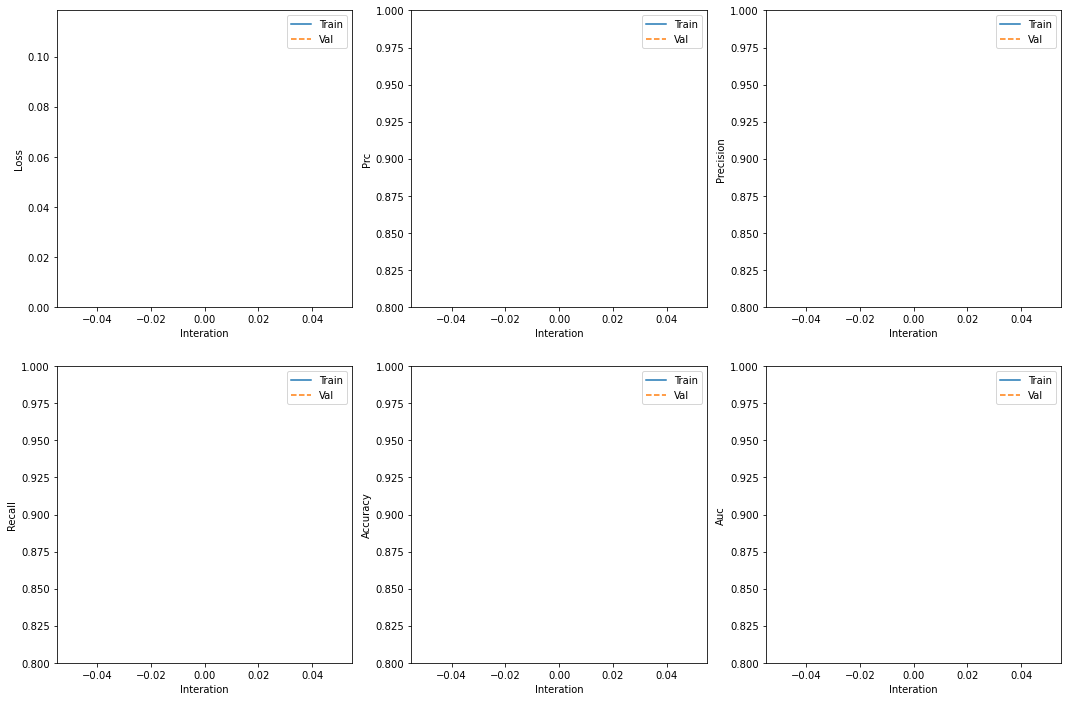

In [39]:
plot_metrics(history)

In [40]:
def plot_roc(name, labels, predictions, **kwargs):
    fp, tp, _ = sklearn.metrics.roc_curve(labels, predictions)

    plt.plot(100*fp, 100*tp, label=name, linewidth=2, **kwargs)
    plt.xlabel('False positives [%]')
    plt.ylabel('True positives [%]')
    plt.xlim([-0.5,20])
    plt.ylim([80,100.5])
    plt.grid(True)
    ax = plt.gca()
    ax.set_aspect('equal')

In [41]:
# plot_roc("Train Baseline", y_train, train_predictions_baseline, color=colors[0])
# plot_roc("Test Baseline", y_test, test_predictions_baseline, color=colors[0], linestyle='--')
# plt.legend(loc='lower right')

In [42]:
def convertPredToData(predictions, inputs):
    predicted_rows = []
    for idx, x in np.ndenumerate(inputs):
        label = 'Benign'
        if (predictions[idx] > 0.6):
            label = 'Malicious'
        else:
            label = 'Benign'
        predicted_rows.append([x, label])

    data = pd.DataFrame(predicted_rows, columns=["url", "label"])
    return data

In [43]:
# sample testing with 200 Random Records.
# get 200 sample records from 1M records.
x_test_sample = x_test.sample(frac=0.0014)

predictions = model.predict(x_test_sample)
df = convertPredToData(predictions, x_test_sample)

print(df)

                                                   url      label
0    https://www.linkedin.com/pub/stephen-hunter/14...     Benign
1                            https://www.wn.com/Honore     Benign
2      https://www.en.wikipedia.org/wiki/Jesse_Murdock     Benign
3    https://www.tonyskansascity.com/2011/07/kansas...     Benign
4    https://www.motortrend.com/roadtests/trucks/11...     Benign
..                                                 ...        ...
253                      terryjenkinsexhibition.co.uk/     Benign
254  http://www.hellooyun.com/php/ww2usaa/www32ew/u...  Malicious
255        https://www.med.umkc.edu/news/default.shtml     Benign
256           https://www.en.wikipedia.org/wiki/Dublin     Benign
257                                   redtube.com/1558     Benign

[258 rows x 2 columns]


In [44]:
# df_list = df.values.tolist()
# JSONP_data = jsonpify(df_list)
# return JSONP_data

In [45]:
# Change this to True if you want to test the flow rapidly.
# Train with a small dataset and only 1 epoch. The model will work poorly
# but this provides a fast way to test if the conversion works end to end.

# _FAST_TRAINING = False
# _EPOCHS = 5

# x_train_ds = tf.convert_to_tensor(pd.DataFrame(x_train))
# y_train_ds = tf.convert_to_tensor(pd.DataFrame(y_train))
# x_test_ds = tf.convert_to_tensor(pd.DataFrame(x_test))
# y_test_ds = tf.convert_to_tensor(pd.DataFrame(y_test))
    
# if _FAST_TRAINING:
#     _EPOCHS = 1
#     _TRAINING_DATA_COUNT = 1000
#     # Get split to small Dataset.
#     x_train_ds = x_train[:_TRAINING_DATA_COUNT]
#     y_train_ds = y_train[:_TRAINING_DATA_COUNT]
#     x_test_ds = x_test[:_TRAINING_DATA_COUNT]
#     y_test_ds = y_test[:_TRAINING_DATA_COUNT]
#     # Convert to Tensors.
#     x_train_ds = tf.convert_to_tensor(pd.DataFrame(x_train_ds))
#     y_train_ds = tf.convert_to_tensor(pd.DataFrame(y_train_ds))
#     x_test_ds = tf.convert_to_tensor(pd.DataFrame(x_test_ds))
#     y_test_ds = tf.convert_to_tensor(pd.DataFrame(y_test_ds))

# model.fit(x_train_ds, y_train_ds, epochs=_EPOCHS)
# model.evaluate(x_test_ds, y_test_ds, verbose=0)

In [46]:
# run_model = tf.function(lambda x: model(x))
# # This is important, let's fix the input size.
# INPUT_SIZE = 200
# concrete_func = run_model.get_concrete_function(
#     tf.TensorSpec([INPUT_SIZE]))

In [47]:
#model directory.
MODEL_DIR = "keras_cnn_model"
model.save(MODEL_DIR)
estimator = tf.keras.estimator.model_to_estimator(keras_model=model, model_dir=MODEL_DIR)

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `

In [48]:
saved_model = tf.keras.models.load_model(MODEL_DIR)

# Check its architecture
saved_model.summary()

# fit loaded model
history_loaded = saved_model.fit(train_dataset, epochs=NO_EPOCHS, validation_data=test_dataset)

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
main_input (InputLayer)         [(None, 1)]          0                                            
__________________________________________________________________________________________________
text_vectorization (TextVectori (None, 200)          0           main_input[0][0]                 
__________________________________________________________________________________________________
embedding (Embedding)           (None, 200, 64)      14912       text_vectorization[0][0]         
__________________________________________________________________________________________________
sequential (Sequential)         (None, 128)          16512       embedding[0][0]                  
______________________________________________________________________________________________

In [49]:
from flask import Flask, jsonify

# initialize our Flask application and the Keras model
app = flask.Flask(__name__)

@app.route('/predict', methods=['POST'])
def predict():
    inputs = np.array(request.json)
    prediction = saved_model.predict(inputs)
    data_df = convertPredToData(predictions, inputs)
    return Response(data_df.to_json(orient="records"), mimetype='application/json')

NameError: name 'flask' is not defined

In [ ]:
if __name__ == '__main__':
    try:
        port = int(sys.argv[1]) # This is for a command-line argument
    except:
        port = 2222
    app.run(port=port, debug=True)